In [66]:
class SIMPLEChannelFlow:
    def __init__(self, nx, ny, dx, dy, dt, rho, nu, F, max_iter, tolerance):
        # Existing initialization code...
        self.F = F
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.rho=rho
        self.dt=dt
        self.dx=dx
        self.dy=dy
        self.nx=nx
        self.ny=ny
        self.nu=nu
    def build_up_b(self, u, v):
        b = torch.zeros_like(u)
        dx=self.dx
        dy=self.dy
        dt=self.dt
        rho=self.rho
        b[1:-1,1:-1] = (rho*(1/dt*((u[2:,1:-1]-u[:-2,1:-1])/(2*dx) + (v[1:-1,2:]-v[1:-1,:-2])/(2*dy))
                              - ((u[2:,1:-1]-u[:-2,1:-1])/(2*dx))**2 -
                              2*((u[1:-1,2:]-u[1:-1,:-2])/(2*dy) * (v[2:,1:-1]-v[:-2,1:-1])/(2*dx)) -
                               ((v[1:-1,2:] - v[1:-1,:-2])/(2*dy))**2))
    
        #periodic BC Pressure @ x = 2
    
        b[-1,1:-1] = (rho*(1/dt*((u[0,1:-1]-u[-2,1:-1])/(2*dx) + (v[-1,2:]-v[-1,:-2])/(2*dy))
                              - ((u[0,1:-1]-u[-2,1:-1])/(2*dx))**2 -
                              2*((u[-1,2:]-u[-1,:-2])/(2*dy) * (v[0,1:-1]-v[-2,1:-1])/(2*dx)) -
                               ((v[-1,2:] - v[-1,:-2])/(2*dy))**2))
          
    
    
        #periodic BC Pressure @ x = 0
    
        b[0,1:-1] = (rho*(1/dt*((u[1,1:-1]-u[-1,1:-1])/(2*dx) + (v[0,2:]-v[0,:-2])/(2*dy))
                              - ((u[1,1:-1]-u[-1,1:-1])/(2*dx))**2 -
                              2*((u[0,2:]-u[0,:-2])/(2*dy) * (v[1,1:-1]-v[-1,1:-1])/(2*dx)) -
                               ((v[0,2:] - v[0,:-2])/(2*dy))**2))
    
        return b

    def pressure_poisson_periodic(self,p,b, dx, dy):
        pn = torch.empty_like(p)
        iteration=500
        
        for q in range(iteration):
            pn = p.clone()
    
            p[1:-1,1:-1] = (((pn[2:,1:-1] + pn[:-2,1:-1])*(dy**2) 
                             + (pn[1:-1,2:]+p[1:-1,:-2])*(dx**2)) /(2*(dx**2 + dy**2)) 
                             - dx**2 * dy**2/(2 * (dx**2 + dy**2)) * b[1:-1,1:-1])
                    
            
    
         #periodic BC Pressure @ x = 2
    
            p[-1,1:-1] = (((pn[0,1:-1] + pn[-2,1:-1])*(dy**2) + (pn[-1,2:]+p[-1,:-2])*(dx**2)) /
                          (2*(dx**2 + dy**2)) - dx**2 * dy**2/(2 * (dx**2 + dy**2)) * b[-1,1:-1])
    
        #periodic BC Pressure @ x = 0
    
            p[0,1:-1] = (((pn[1,1:-1] + pn[-1,1:-1])*(dy**2) + (pn[0,2:]+p[0,:-2])*(dx**2)) /
                            (2*(dx**2 + dy**2)) - dx**2 * dy**2/(2 * (dx**2 + dy**2)) * b[0,1:-1])
    
        #wall bc, pressure
    
            p[:,-1] = p[:,-2]  #dp/dy = 0 at y = 2
            p[:,0]  = p[:,1]   #dp/dy = 0 at y = 0
    
        return p

    def solve_momentum(self,u,v,un,vn,p):
        #Solving X Momentum
        dt=self.dt
        dx=self.dx
        dy=self.dy
        rho=self.rho
        nu=self.nu
        
        u[1:-1,1:-1] = (un[1:-1,1:-1] - un[1:-1,1:-1]*((dt/dx)*(un[1:-1,1:-1]-un[:-2,1:-1]))
        - vn[1:-1,1:-1]*((dt/dy)*(un[1:-1,1:-1]-un[1:-1,:-2])) - ((dt/rho*2*dx)*(p[2:,1:-1]-p[:-2,1:-1]))
        + nu*(((dt/dx**2)*(un[2:,1:-1]-2*un[1:-1,1:-1]+un[:-2,1:-1]))
                          + ((dt/dy**2)*(un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,:-2]))) + self.F * dt)
    
        #Solving Y Momentum
    
        v[1:-1,1:-1] = (vn[1:-1,1:-1] - un[1:-1,1:-1]*((dt/dx)*(vn[1:-1,1:-1]-vn[:-2,1:-1]))
        - vn[1:-1,1:-1]*((dt/dy)*(vn[1:-1,1:-1]-vn[1:-1,:-2])) - ((dt/rho*2*dy)*(p[1:-1,2:]-p[1:-1,:-2]))
        + nu*(((dt/dx**2)*(vn[2:,1:-1]-2*vn[1:-1,1:-1]+vn[:-2,1:-1]))
                          + ((dt/dy**2)*(vn[1:-1,2:]-2*vn[1:-1,1:-1]+vn[1:-1,:-2]))))
        return(u,v)

    def apply_boundary_conditions(self,u,v,un,vn,p):
        # Periodic BC u @ x = 2
        dx=self.dx
        dt=self.dt
        dy=self.dy
        rho=self.rho
        nu=self.nu
        F=self.F
        u[-1,1:-1] = (un[-1,1:-1] - un[-1,1:-1]*((dt/dx)*(un[-1,1:-1]-un[-2,1:-1]))
        - vn[-1,1:-1]*((dt/dy)*(un[-1,1:-1]-un[-1,:-2])) - ((dt/rho*2*dx)*(p[0,1:-1]-p[-2,1:-1]))
        + nu*(((dt/dx**2)*(un[0,1:-1]-2*un[-1,1:-1]+un[-2,1:-1]))
                          + ((dt/dy**2)*(un[-1,2:]-2*un[-1,1:-1]+un[-1,:-2]))) + F * dt)
    
        # Periodic BC u @ x = 0
    
        u[0,1:-1] = (un[0,1:-1] - un[0,1:-1]*((dt/dx)*(un[0,1:-1]-un[-1,1:-1]))
        - vn[0,1:-1]*((dt/dy)*(un[0,1:-1]-un[0,:-2])) - ((dt/rho*2*dx)*(p[1,1:-1]-p[-1,1:-1]))
        + nu*(((dt/dx**2)*(un[1,1:-1]-2*un[0,1:-1]+un[-1,1:-1]))
                          + ((dt/dy**2)*(un[0,2:]-2*un[0,1:-1]+un[0,:-2]))) + F * dt)
        
        # Periodic BC v @ X = 2
    
        v[-1,1:-1] = (vn[-1,1:-1] - un[-1,1:-1]*((dt/dx)*(vn[-1,1:-1]-vn[-2,1:-1]))
        - vn[-1,1:-1]*((dt/dy)*(vn[-1,1:-1]-vn[-1,:-2])) - ((dt/rho*2*dy)*(p[-1,2:]-p[-1,:-2]))
        + nu*(((dt/dx**2)*(vn[0,1:-1]-2*vn[-1,1:-1]+vn[-2,1:-1]))
                          + ((dt/dy**2)*(vn[-1,2:]-2*vn[-1,1:-1]+vn[-1,:-2]))))
    
        # Periodic BC v @ X = 0
    
        v[0,1:-1] = (vn[0,1:-1] - un[0,1:-1]*((dt/dx)*(vn[0,1:-1]-vn[-1,1:-1]))
        - vn[0,1:-1]*((dt/dy)*(vn[0,1:-1]-vn[0,:-2])) - ((dt/rho*2*dy)*(p[0,2:]-p[0,:-2]))
        + nu*(((dt/dx**2)*(vn[1,1:-1]-2*vn[0,1:-1]+vn[-1,1:-1]))
                          + ((dt/dy**2)*(vn[0,2:]-2*vn[0,1:-1]+vn[0,:-2]))))
    
        #WALL no slip condition
    
        u[:,0] = 0
        u[:,-1]= 0
    
        #WALL no penetration condition
        
        v[:,0] = 0
        v[:,-1]= 0
        return(u,v)

    def check_convergence(self, un, vn):
        # Check convergence based on the residual calculation from the open-source code
        pass

    def run_simulation(self,u,v,p):
        residual=1
        iterations=0
        while residual>0.01:
            b = torch.zeros((self.nx, self.ny))
            dx=self.dx
            rho=self.rho
            dy=self.dy
            dt=self.dt
            un = u.clone()
            vn = v.clone()
            #start with initial velocity field u,v
            b = self.build_up_b( u, v)
            p = self.pressure_poisson_periodic(p,b, dx, dy)
            u,v=self.solve_momentum(u,v,un,vn,p)
            u,v=self.apply_boundary_conditions(u,v,un,vn,p)
            residual = (torch.sum(u) - torch.sum(un)) / torch.sum(u)
            iterations += 1
        print(iterations)
        return(u,v,p)

# Example usage
nx=129
ny=129
y_values = torch.linspace(-0.5, 0.5, ny)
x_values=torch.linspace(0,10,nx)
x_mesh, y_mesh = torch.meshgrid(x_values, y_values)
u_inlet=0.1*1.5*(1-4*y_mesh**2).T
v_inlet=torch.zeros_like(u_inlet)
pressure_outlet=torch.ones_like(u_inlet)
if torch.cuda.is_available():
    u_inlet = u_inlet.to('cuda')
    v_inlet = v_inlet.to('cuda')
    pressure_outlet = pressure_outlet.to('cuda')
simulator = SIMPLEChannelFlow(nx, ny, 10/128, 1/128, 0.0002, 1000, 10**-6, 1, 1000, 0.01)
#any initialization that fits the boundary conditions
initial_u=torch.zeros((simulator.nx,simulator.ny))
initial_u=u_inlet
initial_v=torch.zeros_like(initial_u)
initial_p = torch.zeros((simulator.nx,simulator.ny))
if torch.cuda.is_available():
    initial_u = initial_u.to('cuda')
    initial_v = initial_v.to('cuda')
    initial_p = initial_p.to('cuda')
U, V, P = simulator.run_simulation(initial_u,initial_v,initial_p)


1


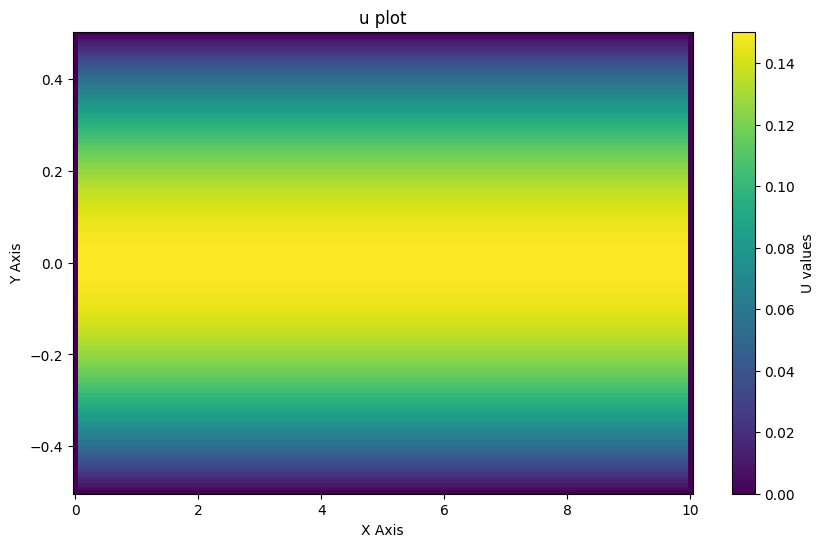

In [67]:
import matplotlib.pyplot as plt

%matplotlib inline
if torch.is_tensor(U):
    U = U.to('cpu').numpy()

#u[:, 0]
#plt.imshow(U)
#plt.colorbar()
#plt.title("X Component of Velocity Field")
#plt.show()
#print(U)
# Create a meshgrid for X and Y data
import numpy as np
x_mesh, y_mesh = np.meshgrid(x_values, y_values)

# Convert U to numpy if it's a tensor
if torch.is_tensor(U):
    U = U.to('cpu').numpy()
    V=V.to('cpu').numpy()
    P=P.to('cpu').numpy()

plt.figure(figsize=(10, 6))
plt.pcolormesh(x_mesh, y_mesh, U, shading='auto')
plt.colorbar(label='U values')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('u plot')
plt.show()
